# Google Colab 기본 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import yaml, os

extract_path = "/content/drive/MyDrive/final year car paint defect.v1i.yolov8_bbox/"

yaml_path = os.path.join(extract_path, "data.yaml")
with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

print(data_yaml)

# 클래스명
class_names = data_yaml['names']
print("클래스 목록:", class_names)



{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 4, 'names': ['dirt', 'runs', 'scratch', 'water marks'], 'roboflow': {'workspace': 'poli-h7nww', 'project': 'final-year-car-paint-defect', 'version': 1, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/poli-h7nww/final-year-car-paint-defect/dataset/1'}}
클래스 목록: ['dirt', 'runs', 'scratch', 'water marks']


데이터 프레임 생성

In [ ]:
import glob
import pandas as pd

label_dir = os.path.join(extract_path, "train", "labels")

bbox_data = []
for file in glob.glob(f"{label_dir}/*.txt"):
    with open(file, 'r') as f:
        for line in f:
            cls_id, x, y, w, h = map(float, line.strip().split())
            bbox_data.append([int(cls_id), x, y, w, h])

df = pd.DataFrame(bbox_data, columns=["class_id", "x_center", "y_center", "width", "height"])
df["class_name"] = df["class_id"].apply(lambda x: class_names[x])
df["area"] = df["width"] * df["height"]
df["aspect_ratio"] = df["width"] / df["height"]

print(df)


      class_id  x_center  y_center     width    height   class_name      area  \
0            1  0.355903  0.335286  0.457899  0.641276         runs  0.293640   
1            0  0.027344  0.300000  0.018750  0.021094         dirt  0.000396   
2            0  0.775000  0.210156  0.016406  0.035937         dirt  0.000590   
3            1  0.514865  0.627441  0.346137  0.616862         runs  0.213519   
4            2  0.395783  0.714417  0.116219  0.569174      scratch  0.066149   
...        ...       ...       ...       ...       ...          ...       ...   
1027         3  0.702344  0.248438  0.033594  0.057031  water marks  0.001916   
1028         3  0.771094  0.358594  0.048438  0.089844  water marks  0.004352   
1029         3  0.815625  0.220312  0.048438  0.057031  water marks  0.002762   
1030         3  0.814063  0.337500  0.029687  0.057031  water marks  0.001693   
1031         3  0.335938  0.498437  0.083594  0.107813  water marks  0.009012   

      aspect_ratio  
0     

# 데이터분석

In [ ]:
from IPython.display import display

display(df.info())
display(df.describe())
display(df.describe().T[["min", "25%", "50%", "75%", "max"]])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032 entries, 0 to 1031
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   class_id      1032 non-null   int64  
 1   x_center      1032 non-null   float64
 2   y_center      1032 non-null   float64
 3   width         1032 non-null   float64
 4   height        1032 non-null   float64
 5   class_name    1032 non-null   object 
 6   area          1032 non-null   float64
 7   aspect_ratio  1032 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 64.6+ KB


None

,class_id,x_center,y_center,width,height,area,aspect_ratio
count,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000
mean,1.298450,0.518240,0.466452,0.136384,0.179295,0.050928,0.852250
std,1.249666,0.242740,0.227418,0.180339,0.219000,0.096087,0.813142
min,0.000000,0.010937,0.010937,0.004687,0.006250,0.000049,0.040477
25%,0.000000,0.377930,0.292969,0.016406,0.025781,0.000396,0.521739
50%,1.000000,0.514062,0.483594,0.048047,0.073438,0.003951,0.665694
75%,3.000000,0.692209,0.618693,0.196713,0.258063,0.048801,0.848197
max,3.000000,0.995313,0.990625,0.991211,0.936002,0.830997,8.313649


,min,25%,50%,75%,max
class_id,0.000000,0.000000,1.000000,3.000000,3.000000
x_center,0.010937,0.377930,0.514062,0.692209,0.995313
y_center,0.010937,0.292969,0.483594,0.618693,0.990625
width,0.004687,0.016406,0.048047,0.196713,0.991211
height,0.006250,0.025781,0.073438,0.258063,0.936002
area,0.000049,0.000396,0.003951,0.048801,0.830997
aspect_ratio,0.040477,0.521739,0.665694,0.848197,8.313649


폴리곤 vs 바운딩박스 수

In [ ]:
import os

base_label_dir = '/content/drive/MyDrive/final year car paint defect.v1i.yolov8/train/labels'

bbox_count = 0
polygon_count = 0
total_files = 0

for fname in os.listdir(base_label_dir):
    if not fname.endswith('.txt'):
        continue
    total_files += 1
    path = os.path.join(base_label_dir, fname)
    with open(path, 'r') as f:
        for line in f:
            num_values = len(line.strip().split())
            if num_values == 5:
                bbox_count += 1
            elif num_values > 5 and num_values % 2 == 1:
                polygon_count += 1
            else:
                print(f"[⚠️형식오류] {fname} → {line.strip()}")

print("=== 📊 라벨 형식 통계 ===")
print(f"총 라벨 파일 수        : {total_files}")
print(f"바운딩 박스 개수 (bbox): {bbox_count}")
print(f"폴리곤 개수 (polygon)  : {polygon_count}")


=== 📊 라벨 형식 통계 ===
총 라벨 파일 수        : 240
바운딩 박스 개수 (bbox): 698
폴리곤 개수 (polygon)  : 334


#데이터 탐색

In [ ]:
# 클래스별 개수
class_counts = df["class_name"].value_counts()
print("클래스별 객체 수:\n", class_counts)

# 이미지당 객체 수 계산
objects_per_image = {}
for file in glob.glob(os.path.join(label_dir, "*.txt")):
    with open(file, 'r') as f:
        count = len(f.readlines())
        image_id = os.path.basename(file).replace(".txt", "")
        objects_per_image[image_id] = count
df_img = pd.DataFrame(list(objects_per_image.items()), columns=["image_id", "object_count"])
print("\n이미지당 객체 수 통계:")
print(df_img["object_count"].describe())

# 클래스별 평균 box 크기
avg_box_size = df.groupby("class_name")[["width", "height", "area"]].mean()
print("\n클래스별 평균 box 크기:")
print(avg_box_size)

# 이상치 예시 (면적이 큰 박스들)
outliers = df[df["area"] > 0.2]
print("\n면적이 큰 이상치 예시:")
print(outliers.sort_values("area", ascending=False).head(5))


클래스별 객체 수:
 class_name
dirt           437
water marks    260
scratch        225
runs           110
Name: count, dtype: int64

이미지당 객체 수 통계:
count    240.00000
mean       4.30000
std        4.08815
min        1.00000
25%        2.00000
50%        3.00000
75%        5.00000
max       26.00000
Name: object_count, dtype: float64

클래스별 평균 box 크기:
                width    height      area
class_name                               
dirt         0.015882  0.025154  0.000439
runs         0.429843  0.516680  0.236133
scratch      0.290831  0.387283  0.103754
water marks  0.081106  0.115643  0.011716

면적이 큰 이상치 예시:
     class_id  x_center  y_center     width    height class_name      area  \
880         1  0.487739  0.574056  0.975477  0.851888       runs  0.830997   
99          1  0.538737  0.441895  0.673828  0.883789       runs  0.595522   
714         1  0.398763  0.623372  0.738932  0.748698       runs  0.553237   
344         1  0.334744  0.606608  0.669488  0.786784       runs  0.526742   

#데이터 시각화

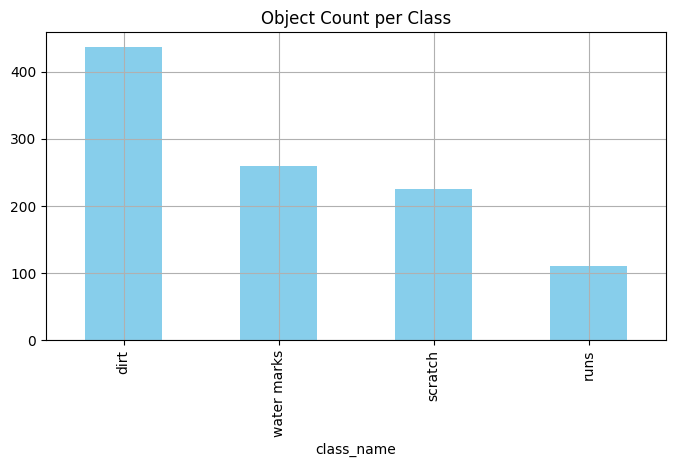

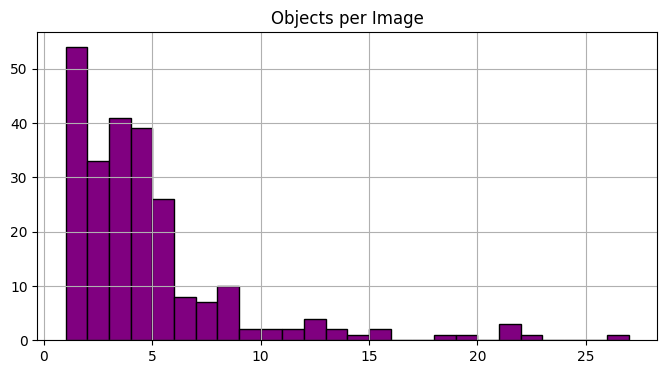

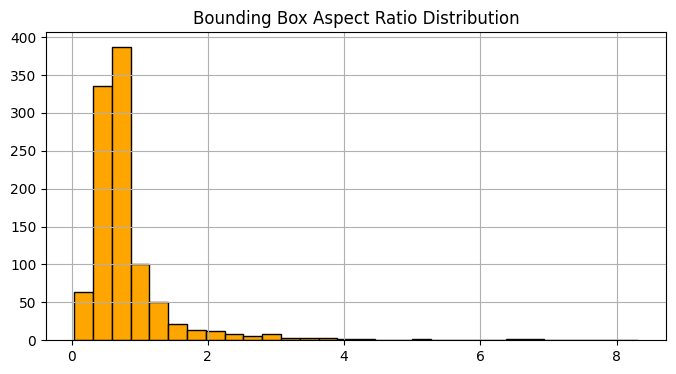

<Figure size 1000x400 with 0 Axes>

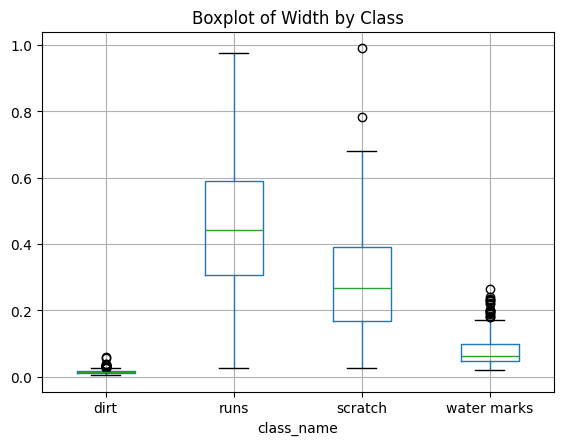

<Figure size 1000x400 with 0 Axes>

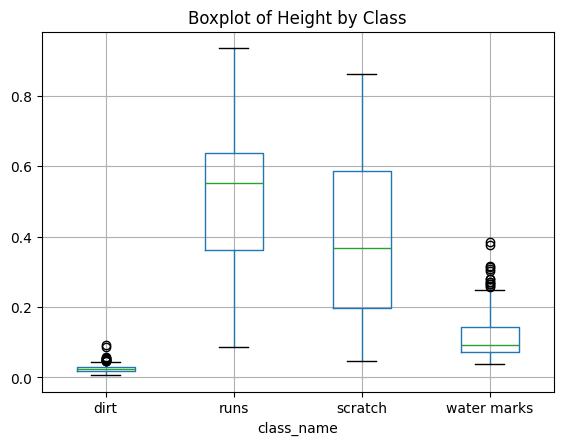

,class_id,x_center,y_center,width,height,class_name,area,aspect_ratio
880,1,0.487739,0.574056,0.975477,0.851888,runs,0.830997,1.145077
99,1,0.538737,0.441895,0.673828,0.883789,runs,0.595522,0.762431
714,1,0.398763,0.623372,0.738932,0.748698,runs,0.553237,0.986956
344,1,0.334744,0.606608,0.669488,0.786784,runs,0.526742,0.850917
278,1,0.444878,0.668687,0.766059,0.630994,runs,0.483379,1.214051


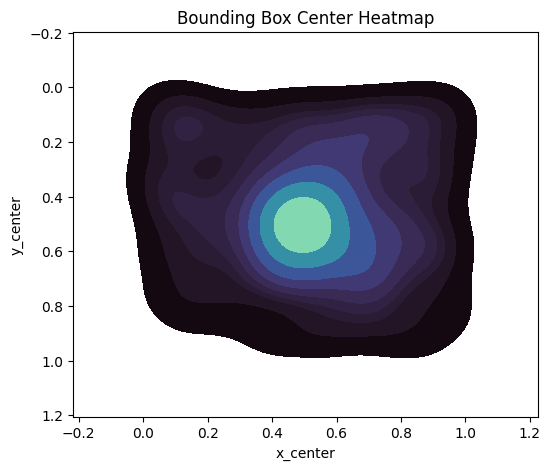

In [ ]:
import matplotlib.pyplot as plt

# 클래스별 객체 수
plt.figure(figsize=(8, 4))
class_counts.plot(kind="bar", color="skyblue")
plt.title("Object Count per Class")
plt.grid(True)
plt.show()

# 이미지당 객체 수 히스토그램
plt.figure(figsize=(8, 4))
plt.hist(df_img["object_count"], bins=range(1, df_img["object_count"].max() + 2), color="purple", edgecolor="black")
plt.title("Objects per Image")
plt.grid(True)
plt.show()

# 바운딩박스 비율 분포
plt.figure(figsize=(8, 4))
plt.hist(df["aspect_ratio"], bins=30, color="orange", edgecolor="black")
plt.title("Bounding Box Aspect Ratio Distribution")
plt.grid(True)
plt.show()

# 박스 크기 boxplot (width / height)
plt.figure(figsize=(10, 4))
df.boxplot(column="width", by="class_name")
plt.title("Boxplot of Width by Class")
plt.suptitle("")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
df.boxplot(column="height", by="class_name")
plt.title("Boxplot of Height by Class")
plt.suptitle("")
plt.grid(True)
plt.show()

# 이상치 출력
display(outliers.sort_values("area", ascending=False).head(5))

#밀도 분포(heatmap) 시각화
import seaborn as sns
plt.figure(figsize=(6,5))
sns.kdeplot(data=df, x="x_center", y="y_center", fill=True, cmap="mako", thresh=0.05)
plt.title("Bounding Box Center Heatmap")
plt.gca().invert_yaxis()  # 이미지 좌표 기준
plt.show()

이미지 파일 예시

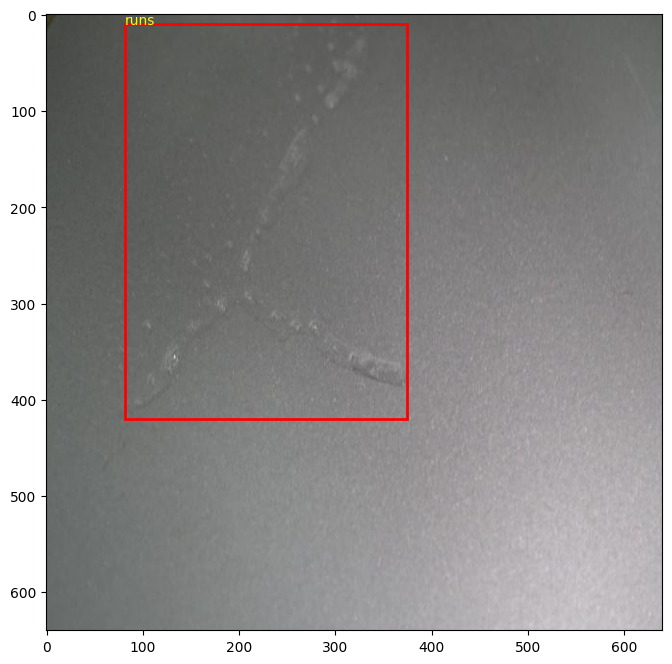

In [ ]:
import cv2
from matplotlib import patches

def visualize_sample(image_path, label_path):
    img = cv2.imread(image_path)[:,:,::-1]
    h, w, _ = img.shape

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.imshow(img)

    with open(label_path, 'r') as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.split())
            cls = int(cls)

            # YOLO 좌표 → 픽셀 좌표 변환
            x1 = (x - bw/2) * w
            y1 = (y - bh/2) * h
            rect = patches.Rectangle((x1, y1), bw*w, bh*h,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, class_names[cls], color='yellow', fontsize=10)

    plt.show()

# 샘플 1개 시각화
sample_img = train_img[0]
sample_lbl = sample_img.replace("images", "labels").replace(".jpg", ".txt")
visualize_sample(sample_img, sample_lbl)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!pip install --upgrade torch torchvision torchaudio
!pip install --upgrade ultralytics


# 데이터 전처리

데이터셋에 바운딩박스와 폴리곤 객체이터셋에 함께 있어 폴리곤 -> 바운딩박스 최소 외접 사격으로 변환

In [ ]:

# 폴리곤 데이터 박스 데이터로 변환

import os
import numpy as np
from tqdm import tqdm
import shutil

base_dir = '/content/drive/MyDrive/final year car paint defect.v1i.yolov8'
output_dir = base_dir + '_bbox'  # 변환된 데이터셋 저장 경로

sets = ['train', 'valid', 'test']

def convert_polygon_to_bbox_line(line):
    nums = list(map(float, line.strip().split()))
    if len(nums) == 5:
        return line.strip()  # 이미 bbox 형식이면 그대로 사용
    cls = int(nums[0])
    coords = np.array(nums[1:]).reshape(-1, 2)
    xmin, ymin = coords.min(axis=0)
    xmax, ymax = coords.max(axis=0)
    cx, cy = (xmin + xmax) / 2, (ymin + ymax) / 2
    w, h = xmax - xmin, ymax - ymin
    return f"{cls} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}"

for split in sets:
    label_dir = os.path.join(base_dir, split, 'labels')
    img_dir = os.path.join(base_dir, split, 'images')

    out_label_dir = os.path.join(output_dir, split, 'labels')
    out_img_dir = os.path.join(output_dir, split, 'images')
    os.makedirs(out_label_dir, exist_ok=True)
    os.makedirs(out_img_dir, exist_ok=True)

    print(f" {split} 변환 중...")

    for fname in tqdm(os.listdir(label_dir)):
        src_label_path = os.path.join(label_dir, fname)
        dst_label_path = os.path.join(out_label_dir, fname)

        # Polygon 라벨 → Bounding Box
        with open(src_label_path, 'r') as f:
            lines = f.readlines()
        converted_lines = [convert_polygon_to_bbox_line(line) for line in lines]

        with open(dst_label_path, 'w') as f:
            f.write('\n'.join(converted_lines))

        # 이미지도 복사
        img_name = fname.replace('.txt', '.jpg')
        src_img_path = os.path.join(img_dir, img_name)
        dst_img_path = os.path.join(out_img_dir, img_name)
        if os.path.exists(src_img_path):
            shutil.copyfile(src_img_path, dst_img_path)

print(" Polygon → BBox 변환 완료!")
print(f" 결과 경로: {output_dir}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install --upgrade torch torchvision torchaudio
!pip install --upgrade ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 134.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
from ultralytics import YOLO
import shutil

# ✅ 데이터 경로
data_yaml_path = "/content/drive/MyDrive/final year car paint defect.v1i.yolov8_bbox/data.yaml"

# ✅ 모델 로드
model = YOLO("yolov8m.pt")  # 사전 학습된 yolov8m

# ✅ 학습
model.train(
    data=data_yaml_path,
    epochs=100,
    imgsz=640,
    batch=16,
    name='paint_defect_yolo_bbox',
    lr0=0.005,
    optimizer='SGD',
    patience=30,
    augment=True,
    cos_lr=True,
    warmup_epochs=3,
    val=True,
    cache=True
)

# ✅ 훈련 결과 디렉토리
trained_model_path = "runs/detect/paint_defect_yolo_bbox/weights/best.pt"

# ✅ 원하는 위치로 모델 저장
final_model_path = "/content/drive/MyDrive/paint_defect_yolov8m_bbox_best.pt"
shutil.copy(trained_model_path, final_model_path)

print(f"✅ 모델 저장 완료: {final_model_path}")


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/final year car paint defect.v1i.yolov8_bbox/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=paint_defect_yolo_bbox5, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, 

train: Scanning /content/drive/MyDrive/final year car paint defect.v1i.yolov8_bbox/train/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.3GB RAM): 100%|██████████| 240/240 [00:01<00:00, 184.83it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 2.5±2.0 ms, read: 3.9±3.1 MB/s, size: 28.6 KB)


val: Scanning /content/drive/MyDrive/final year car paint defect.v1i.yolov8_bbox/valid/labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 70/70 [00:00<00:00, 102.53it/s]


Plotting labels to runs/detect/paint_defect_yolo_bbox5/labels.jpg... 
optimizer: SGD(lr=0.005, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/paint_defect_yolo_bbox5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.92G      2.554      4.509      2.274         90        640: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all         70        284      0.209     0.0784     0.0552     0.0268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.45G      2.356      3.836       2.11        100        640: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         70        284      0.478      0.118      0.116     0.0558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.95G      2.058      2.934      1.878        153        640: 100%|██████████| 15/15 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         70        284      0.363      0.259      0.252      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.95G      1.741      2.263      1.583        111        640: 100%|██████████| 15/15 [00:08<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         70        284      0.484      0.301      0.304      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.99G      1.681      1.934      1.557         85        640: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all         70        284      0.537      0.367      0.429      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.99G      1.646      1.789      1.519         94        640: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         70        284      0.612      0.344      0.411      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.99G      1.651      1.789      1.516        103        640: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

                   all         70        284      0.558      0.478      0.549      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.99G      1.578      1.722      1.439         52        640: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]

                   all         70        284      0.679      0.256      0.246     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.99G      1.496       1.59      1.413        125        640: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         70        284      0.517      0.492       0.52       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         7G      1.438      1.375      1.366         93        640: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

                   all         70        284      0.399      0.373      0.415      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.04G      1.507      1.397      1.394         91        640: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         70        284      0.498      0.551      0.537      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.08G      1.521      1.382       1.37        115        640: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         70        284      0.452      0.495      0.492      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.13G      1.466      1.281      1.372        115        640: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         70        284      0.653      0.616      0.632      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.13G      1.564      1.415      1.426         81        640: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         70        284      0.649      0.538      0.549      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.13G      1.443      1.247      1.376        135        640: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         70        284      0.642      0.464      0.476      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.13G      1.478      1.308      1.409        118        640: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         70        284      0.715      0.382      0.467      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.13G      1.461       1.24      1.366        125        640: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         70        284      0.487      0.517      0.496      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.13G      1.506      1.332      1.441        121        640: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]

                   all         70        284      0.643      0.547      0.582      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.13G      1.418      1.178      1.341        104        640: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         70        284      0.606      0.598      0.625       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.13G      1.448       1.23      1.339         81        640: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]

                   all         70        284      0.681      0.483      0.559      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.13G      1.424      1.137       1.33        127        640: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         70        284      0.643      0.539      0.576      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.13G      1.416      1.122      1.319         78        640: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         70        284      0.666      0.519       0.58      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.13G      1.387       1.14      1.349         59        640: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         70        284       0.67      0.596      0.602      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.13G      1.442      1.138      1.361         96        640: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         70        284      0.624       0.59      0.587      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.13G      1.419       1.15      1.318        117        640: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]

                   all         70        284      0.649      0.635      0.655      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.13G      1.407      1.146      1.314        112        640: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all         70        284      0.573      0.381      0.403      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.13G      1.416       1.15      1.329        120        640: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         70        284      0.633      0.623      0.641      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.13G      1.399      1.142      1.303        115        640: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         70        284      0.626      0.505      0.538      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.13G      1.417      1.107       1.34         82        640: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         70        284       0.71      0.667       0.71      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.13G      1.369      1.104      1.309         88        640: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


                   all         70        284      0.683      0.719      0.723      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.13G      1.372      1.098      1.312        149        640: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         70        284      0.717      0.662      0.714       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.17G      1.366      1.041      1.278         89        640: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         70        284       0.68       0.67      0.709      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.22G      1.354      1.033      1.293         94        640: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         70        284      0.739      0.668      0.712      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.22G       1.41      1.036       1.29         79        640: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         70        284      0.724        0.7      0.724      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.22G      1.368      1.034      1.279         98        640: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         70        284      0.669      0.439      0.523      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.22G      1.361      1.043      1.297        119        640: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         70        284      0.685      0.655      0.683      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.22G      1.337      1.005      1.256        100        640: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         70        284      0.742       0.63       0.68      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.22G        1.3     0.9476      1.264        159        640: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         70        284      0.694      0.636      0.667      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.22G      1.333     0.9576      1.258        133        640: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         70        284      0.693      0.717      0.726      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.22G      1.267     0.9754      1.232        109        640: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         70        284      0.736      0.728      0.754      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.22G      1.267     0.8996      1.222        138        640: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         70        284       0.73      0.705      0.726       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.22G      1.281     0.8881      1.221        132        640: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         70        284      0.722      0.723      0.744      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.22G      1.252     0.9189      1.243        104        640: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         70        284      0.727      0.572      0.614      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.22G      1.256     0.9157      1.202         83        640: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         70        284      0.766      0.456      0.545      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.22G      1.248     0.9015      1.209        104        640: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         70        284      0.725      0.711      0.752      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.22G      1.198     0.8411      1.199         90        640: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         70        284      0.746       0.68      0.734      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.26G      1.226     0.8653      1.205        110        640: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all         70        284       0.68      0.667      0.688      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.31G      1.254     0.8805      1.215         92        640: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         70        284      0.704      0.668      0.693      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.31G      1.199     0.8424      1.207        105        640: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         70        284      0.748      0.726      0.742      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.31G      1.193     0.8835      1.187         91        640: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         70        284      0.737      0.756      0.757      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.31G      1.147     0.8182      1.156        117        640: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         70        284      0.725      0.727      0.731      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.31G      1.191     0.8134      1.193        104        640: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all         70        284       0.68      0.506      0.578      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.31G      1.215      0.866      1.193         88        640: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         70        284      0.682      0.755      0.735      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.31G      1.179     0.8356      1.187         89        640: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         70        284      0.712      0.696      0.724      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.31G      1.143     0.8366      1.175        110        640: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all         70        284       0.71      0.735      0.746      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.31G      1.149     0.8256      1.159         94        640: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         70        284       0.71      0.701      0.703      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.31G       1.13     0.7879      1.157        105        640: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all         70        284      0.738      0.693      0.742      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.31G      1.136     0.8057      1.164        122        640: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         70        284      0.741      0.755      0.783      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.31G      1.117     0.7794      1.131         94        640: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         70        284      0.732      0.728      0.765      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.31G      1.081     0.7547      1.123        136        640: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         70        284      0.724      0.714      0.721      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.31G      1.084     0.7221      1.122        114        640: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         70        284      0.711      0.727      0.747      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.31G      1.086     0.7463      1.146         77        640: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         70        284      0.675      0.593      0.631      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.31G      1.107     0.7578      1.147        100        640: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         70        284      0.724      0.693      0.698      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.31G        1.1     0.7485      1.144         58        640: 100%|██████████| 15/15 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all         70        284      0.741      0.738       0.75      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.31G       1.09     0.7453      1.124        111        640: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]

                   all         70        284      0.764      0.709      0.744      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.31G       1.09     0.7374      1.125         88        640: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         70        284      0.715      0.711       0.72      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.31G      1.054     0.7062      1.108         98        640: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         70        284      0.741      0.688      0.721      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.31G      1.072       0.73      1.146         92        640: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         70        284      0.776       0.71      0.733      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.31G      1.064     0.7253       1.12         97        640: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all         70        284      0.757      0.696      0.723      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.31G      1.058     0.7375      1.118        166        640: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         70        284      0.757      0.715      0.739      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.31G      1.057     0.7291      1.119        145        640: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all         70        284      0.783      0.719      0.743       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.31G      1.016     0.6726      1.095         87        640: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         70        284      0.749      0.686      0.718      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.31G       1.01     0.6898      1.108         95        640: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all         70        284      0.757      0.685      0.724      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.31G      1.012     0.7231      1.112         77        640: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         70        284      0.729      0.744      0.745      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.31G     0.9907       0.69      1.097         98        640: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         70        284      0.751      0.713      0.725      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.31G     0.9774     0.6549      1.074         92        640: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         70        284      0.774      0.718      0.735      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.31G     0.9905     0.6827      1.086         77        640: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         70        284      0.815      0.697      0.739      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.31G      1.046     0.7019      1.092        124        640: 100%|██████████| 15/15 [00:08<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         70        284      0.774      0.731      0.739       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.31G      1.003     0.6694       1.11        103        640: 100%|██████████| 15/15 [00:08<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all         70        284       0.76      0.703      0.716      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.31G      1.021      0.697      1.105         77        640: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         70        284      0.751      0.752       0.75      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.31G     0.9645     0.6673      1.077         97        640: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         70        284      0.745      0.738      0.742      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.31G     0.9913     0.6549      1.086        117        640: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         70        284      0.766      0.721      0.748      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.31G     0.9726     0.6506       1.07        115        640: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         70        284      0.779      0.736      0.758      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.31G     0.9576      0.651      1.062        112        640: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

                   all         70        284      0.746      0.759      0.749      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.31G     0.9756     0.6569      1.085         83        640: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all         70        284      0.753      0.736      0.744      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.31G     0.9958      0.662       1.09         94        640: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         70        284      0.749      0.738      0.747      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.31G     0.9668     0.6343       1.07         81        640: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         70        284      0.791      0.713       0.75      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.31G     0.9454     0.6564       1.06        133        640: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         70        284      0.748      0.758      0.747      0.456
EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 58, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



88 epochs completed in 0.243 hours.
Optimizer stripped from runs/detect/paint_defect_yolo_bbox5/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/paint_defect_yolo_bbox5/weights/best.pt, 52.0MB

Validating runs/detect/paint_defect_yolo_bbox5/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


                   all         70        284      0.725      0.724      0.762      0.452
                  dirt         46        115      0.686      0.644      0.679      0.232
                  runs         29         30      0.842      0.888      0.909      0.644
               scratch         41         70       0.83      0.871       0.89       0.69
           water marks         18         69      0.543      0.493       0.57      0.243
Speed: 0.3ms preprocess, 26.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/paint_defect_yolo_bbox5
✅ 모델 저장 완료: /content/drive/MyDrive/paint_defect_yolov8m_bbox_best.pt


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 11.4±5.7 MB/s, size: 21.1 KB)


val: Scanning /content/drive/MyDrive/final year car paint defect.v1i.yolov8_bbox/test/labels.cache... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


                   all         34        148      0.781      0.741      0.775      0.494
                  dirt         23         64      0.776      0.641      0.758       0.27
                  runs         14         14      0.977          1      0.995      0.768
               scratch         16         30      0.949        0.9      0.931      0.697
           water marks         11         40       0.42      0.425      0.414      0.242
Speed: 0.4ms preprocess, 27.6ms inference, 0.0ms loss, 8.5ms postprocess per image
Results saved to runs/detect/val
 평균 정밀도 (Precision): 0.7807
 평균 재현율 (Recall): 0.7414
 mAP@0.5: 0.7745
 mAP@0.5:0.95: 0.4941

image 1/1 /content/drive/MyDrive/final year car paint defect.v1i.yolov8_bbox/test/images/DSC_0012_JPG.rf.cb1beee9b171a6926283e217474da1d5.jpg: 640x640 1 scratch, 1 water marks, 37.2ms
Speed: 2.4ms preprocess, 37.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


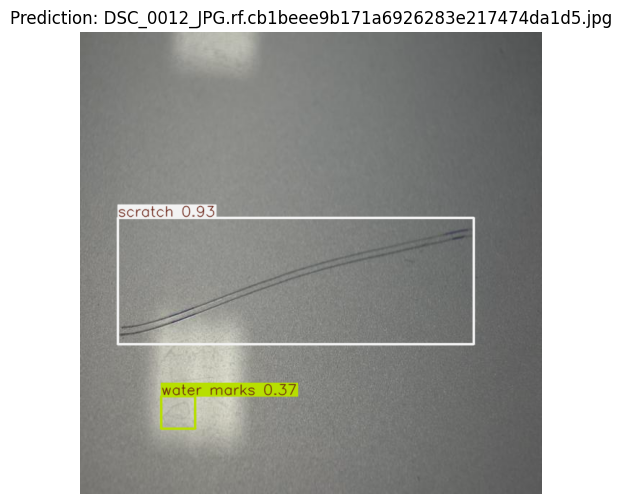


image 1/1 /content/drive/MyDrive/final year car paint defect.v1i.yolov8_bbox/test/images/DSC_0015_JPG.rf.2a587e8dd443a5d44973c3aa4cbc7576.jpg: 640x640 2 dirts, 4 scratchs, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


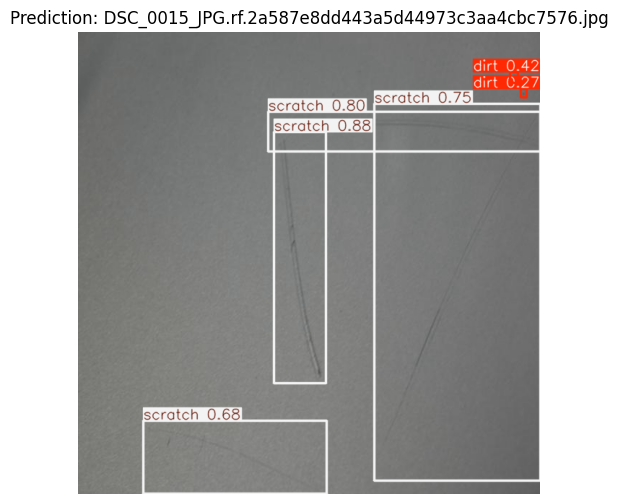


image 1/1 /content/drive/MyDrive/final year car paint defect.v1i.yolov8_bbox/test/images/DSC_0018_JPG.rf.da0ec460ac7f44a810d4e406651390c5.jpg: 640x640 1 scratch, 37.3ms
Speed: 2.6ms preprocess, 37.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


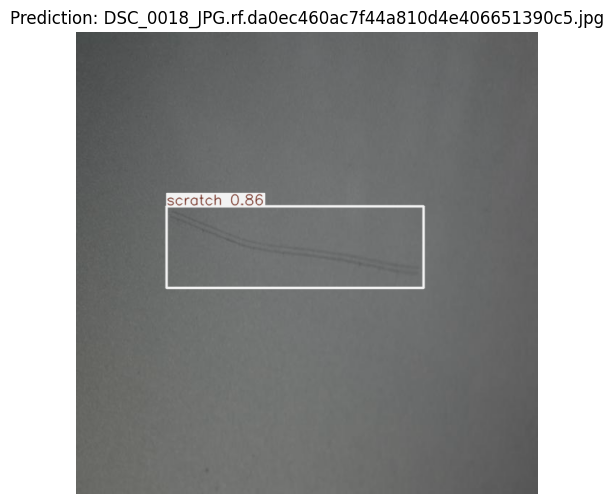

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
import os

#  모델 로드 먼저
model = YOLO("runs/detect/paint_defect_yolo_bbox/weights/best.pt")

#  평가 실행 (테스트셋 기준)
data_yaml_path = "/content/drive/MyDrive/final year car paint defect.v1i.yolov8_bbox/data.yaml"
metrics = model.val(data=data_yaml_path, split='test')

#  성능 지표 출력
mp    = metrics.box.mp        # Mean Precision
mr    = metrics.box.mr        # Mean Recall
map50 = metrics.box.map50     # mAP@0.5
map95 = metrics.box.map       # mAP@0.5:0.95

print(f" 평균 정밀도 (Precision): {mp:.4f}")
print(f" 평균 재현율 (Recall): {mr:.4f}")
print(f" mAP@0.5: {map50:.4f}")
print(f" mAP@0.5:0.95: {map95:.4f}")

#  테스트 이미지 경로 설정
test_img_dir = "/content/drive/MyDrive/final year car paint defect.v1i.yolov8_bbox/test/images"
test_images = sorted([os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.png'))])

#  이미지 시각화 (3장)
for i in range(min(3, len(test_images))):
    results = model.predict(test_images[i], imgsz=640, conf=0.25, iou=0.5, save=False)
    pred_img = results[0].plot()

    plt.figure(figsize=(8, 6))
    plt.imshow(pred_img)
    plt.title(f"Prediction: {os.path.basename(test_images[i])}")
    plt.axis('off')
    plt.show()
